# Heston Model

* [1. Introduction](#1)
* [2. Dynamics modelization](#2)
    * [2.1 effect of $\rho$ on the Terminal stock price density](#2.1)
    * [2.2 effect of $\sigma$ on the Terminal stock price density](#2.2)
    * [2.3. Volatility clustering with the Heston model vs Black-Scholes](#2.3)
    * [2.4. Mean Reversion Effect](#2.4)
* [3. Pricing comparison with Black-Scholes](#3)
    * [3.1 European Options](#3.1)
        * [3.1.1 Implementing Heston Pricing](#3.1.1)
        * [3.1.2 Convergence towards the same value with a monte Carlo simulation](#3.1.2)
        * [3.1.3 Strike dependency](#3.1.3)
        * [3.1.4. Maturity Convergence](#3.1.4)
        * [3.1.5. Falling back to Black-Scholes](#3.1.5)
    * [3.2. Market Data](#3.2)
    * [3.3. Fitting a specific expiration](#3.3)
    * [3.4. Global fit](#3.4)
    * [3.5. Pricing comparison](#3.5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy.stats import gaussian_kde
from statsmodels.tsa.stattools import acf
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import timedelta
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import math

<a id='1' > </a>
# <u>1.Introduction

The Heston model is a popular stochastic volatility framework introduced by Steven Heston in 1993. It improves upon constant volatility models by allowing the volatility of the asset price to evolve over time according to its own stochastic process.

**<u> Model Equations**

In the Heston model, the asset price $S_t$ and its instantaneous variance $v_t$ follow the stochastic differential equations:

$$
dS_t = \mu S_t \, dt + \sqrt{v_t} \, S_t \, dW_t^S,
$$

$$
dv_t = \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v.
$$

Here:
- $\mu$ is the drift rate of the asset.
- $v_t$ is the instantaneous variance (with $\sqrt{v_t}$ being the volatility).
- $\kappa$ is the rate at which $v_t$ reverts to its long-run mean.
- $\theta$ is the long-run mean of the variance.
- $\sigma$ is the volatility of the variance process (often called the "vol-of-vol").
- $W_t^S$ and $W_t^v$ are two Brownian motions with correlation 
  $$
  dW_t^S\, dW_t^v = \rho \, dt,
  $$
  where $\rho$ represents the correlation between the asset price and its volatility.

**<u> Main Results and Advantages**

- One of the key features of the Heston model is that it provides a semi-analytical solution for European option pricing via characteristic functions and Fourier transform techniques.
- The model naturally produces a volatility smile and skew, phenomena that constant volatility models (e.g., Black-Scholes) cannot capture.
- The variance process is mean-reverting, which aligns well with empirical observations in financial markets.
- The model's parameters ($\kappa$, $\theta$, $\sigma$, and $\rho$) are economically meaningful and can be calibrated to market data.

**<u> Industry Usage and Comparison with Other Models**

The Heston model is widely used for pricing derivatives, particularly European and exotic options, as well as for risk management and volatility surface modeling. While the Black-Scholes model assumes constant volatility, the Heston model incorporates stochastic volatility, resulting in a more accurate reflection of market conditions and option price behavior.

**Comparison with Local Volatility Models:** Local volatility models (such as the Dupire model) can exactly fit the observed volatility surface by construction, but they often require a more complex calibration procedure. In contrast, the Heston model, with its fewer parameters and parsimonious structure, strikes a balance between realism and tractability.

This notebook will guide you through the implementation of the Heston model in Python, including parameter calibration and option pricing using the characteristic function approach.


<a id='2' > </a>
# <u>2. Dynamics Modelization

To simulate paths for the asset price $S_t$ and its variance $v_t$, we must discretise the continuous-time stochastic differential equations. A common method is the Euler-Maruyama scheme, which approximates the evolution of the processes over small time steps $\Delta t$.

- **<u>Discretising the Asset Price**

The SDE for the asset price is given by:

$$
dS_t = \mu S_t \, dt + \sqrt{v_t} \, S_t \, dW_t^S.
$$

Using the Euler-Maruyama method, the discretised form over a time step $\Delta t$ is:

$$
S_{t+\Delta t} = S_t + \mu S_t \Delta t + \sqrt{v_t} \, S_t \Delta W_t^S,
$$

where the increment $\Delta W_t^S$ is modeled as:

$$
\Delta W_t^S = \sqrt{\Delta t} \, \epsilon_t^S,
$$

with $\epsilon_t^S \sim N(0,1)$.

- **<u>Discretising the Variance Process**

The variance process follows the SDE:

$$
dv_t = \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v.
$$

Its Euler-Maruyama discretisation is:

$$
v_{t+\Delta t} = v_t + \kappa (\theta - v_t) \Delta t + \sigma \sqrt{v_t} \Delta W_t^v,
$$

with:

$$
\Delta W_t^v = \sqrt{\Delta t} \, \epsilon_t^v,
$$

and $\epsilon_t^v \sim N(0,1)$.

- **<u>Incorporating Correlation**

The Brownian motions $W_t^S$ and $W_t^v$ are correlated with:

$$
dW_t^S\, dW_t^v = \rho \, dt.
$$

To simulate this correlation, one common approach is to define the increments as:

$$
\Delta W_t^S = \sqrt{\Delta t} \, \epsilon_t^S,
$$

$$
\Delta W_t^v = \rho \sqrt{\Delta t} \, \epsilon_t^S + \sqrt{1-\rho^2}\sqrt{\Delta t} \, \epsilon_t^v,
$$

where $\epsilon_t^S$ and $\epsilon_t^v$ are independent standard normal random variables.

- **<u> Considerations and Alternative Schemes**
     
    


Since $v_t$ represents variance, it must remain non-negative. The simple Euler scheme can occasionally yield negative values. One remedy is the **full-truncation Euler scheme**, where any negative $v_t$ is set to zero before computing $\sqrt{v_t}$ in the next time step.

While the Euler-Maruyama method is straightforward, more sophisticated methods like the **Milstein scheme** or the **Quadratic Exponential (QE) scheme** (developed by Andersen) can offer better accuracy and stability, especially for the variance process.



In [2]:
def simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, M, seed=None):
    """
    Simulate the Heston model dynamics for asset price (spot) and variance (volatility squared)
    using the Euler-Maruyama discretisation.

    Parameters:
    - S0 (float): Initial asset price.
    - v0 (float): Initial variance (volatility squared).
    - mu (float): Drift rate of the asset.
    - kappa (float): Speed of mean reversion for the variance.
    - theta (float): Long-run mean of the variance.
    - sigma (float): Volatility of the variance process (vol-of-vol).
    - rho (float): Correlation between the Brownian motions of the asset and variance.
    - T (float): Total time horizon (e.g., in years).
    - N (int): Number of time steps.
    - M (int): Number of simulation paths.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - S (ndarray): Simulated asset price paths, shape (N+1, M).
    - v (ndarray): Simulated variance paths, shape (N+1, M).
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    # Preallocate arrays for asset price and variance
    S = np.zeros((N + 1, M))
    v = np.zeros((N + 1, M))
    
    # Set initial conditions
    S[0] = S0
    v[0] = v0
    
    # Time stepping using Euler-Maruyama discretisation
    for t in range(N):
        # Generate independent standard normal variates
        eps1 = np.random.randn(M)
        eps2 = np.random.randn(M)
        
        # Create correlated Brownian increments
        dW_S = np.sqrt(dt) * eps1
        dW_v = np.sqrt(dt) * (rho * eps1 + np.sqrt(1 - rho**2) * eps2)
        
        # Update variance: full truncation Euler to ensure non-negativity
        v[t+1] = v[t] + kappa * (theta - v[t]) * dt + sigma * np.sqrt(np.maximum(v[t], 0)) * dW_v
        v[t+1] = np.maximum(v[t+1], 0)  # enforce non-negativity
        
        # Update asset price
        S[t+1] = S[t] + mu * S[t] * dt + np.sqrt(np.maximum(v[t], 0)) * S[t] * dW_S
    
    return S, v

To test this we will use the initial parameters that Heston himself used in his introductory paper in 1993

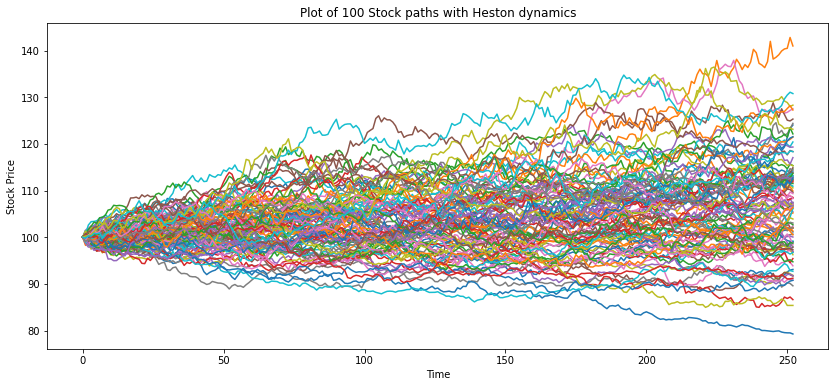

_____________________________________________________________________________________________________


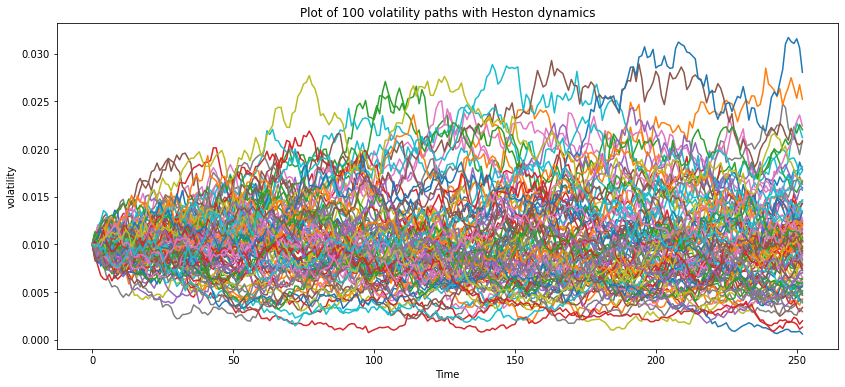

In [3]:
#Set parameters :
S0 = 100
v0 = 0.01
mu = 0.05
kappa = 2
theta = 0.01
sigma = 0.1
rho = 0.5
T = 1

#Set dimensions of simulation : 
N = 252
M = 100
seed = 123

#Launch simulation : 
S_Heston,v_Heston = simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, M, seed=seed)

#plot results for stock price : 
plt.figure(figsize=(14,6))
plt.title(f'Plot of {M} Stock paths with Heston dynamics')
plt.ylabel('Stock Price')
plt.xlabel('Time')
for i in range(0,M):
    plt.plot(S_Heston[:,i])
plt.show()

print('_____________________________________________________________________________________________________')

#plot results for volatility : 
plt.figure(figsize=(14,6))
plt.title(f'Plot of {M} volatility paths with Heston dynamics')
plt.ylabel('volatility')
plt.xlabel('Time')
for i in range(0,M):
    plt.plot(v_Heston[:,i])
plt.show()

to illustrate the flexibility of the model and its adaptability to real market data, we will first demonstrate a few of Heston's results in his introductory paper in 1993.

<a id='2.1' > </a>
## <u>2.1 effect of $\rho$ on the Terminal stock price density

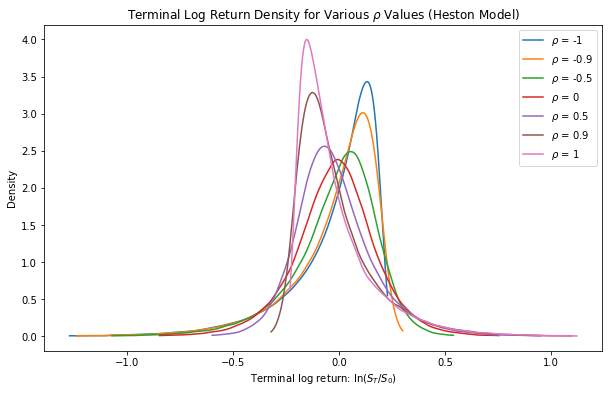

In [4]:
# Parameters
S0 = 100        # Initial stock price
v0 = 0.04       # Initial variance
mu = 0.00       # Drift rate
kappa = 2.0     # Speed of mean reversion
theta = 0.04    # Long-run variance
sigma = 0.5     # Volatility of volatility
seed = 42

T = 1.0         # Terminal time (1 year)
N = 252         # Number of time steps (daily steps)
M = 100000      # Number of simulation paths

# Values of rho to test
rho_values = [-1, -0.9, -0.5, 0, 0.5, 0.9, 1]

plt.figure(figsize=(10, 6))

for rho in rho_values:
    # Simulate Heston dynamics using the previously defined function
    S_Heston, v_Heston = simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, M, seed=seed)
    
    # Compute terminal log return: x = log(S_T/S0)
    terminal_log_returns = np.log(S_Heston[-1] / S0)
    
    # Estimate the density using Gaussian kernel density estimation
    density_estimator = gaussian_kde(terminal_log_returns)
    xs = np.linspace(np.percentile(terminal_log_returns, 0.1), 
                     np.percentile(terminal_log_returns, 99.9), 1000)
    plt.plot(xs, density_estimator(xs), label=f"$\\rho$ = {rho}")

plt.xlabel("Terminal log return: $\\ln(S_T/S_0)$")
plt.ylabel("Density")
plt.title("Terminal Log Return Density for Various $\\rho$ Values (Heston Model)")
plt.legend()
plt.show()


<u> **What do we see here ?** </u>

Heston identified this phenomenon in his paper very clearly : 

"*The correlation parameter $\rho$ positively affects the skewness of spot returns. Intuitively, a positive correlation results in high variance when the spot asset rises, and this “spreads” the right tail of the probability density. Conversely, the left tail is associated with low variance and is not spread out*"

This phenomenon is key to understanding the utility of the Heston model, this effect of skew is specifically what is missing from the Black-Scholes model to explain stock prices more clearly.

We see in market prices that the terminal stock price is negatively skewed and that periods of high volatility are often correlated with diminishing stock returns (we therefore expect a negative value for rho when calibrating to market prices). The Heston model identifies this issue and encapsulates this effect nicely.

<a id='2.2' > </a>
## <u>2.2 effect of $\sigma$ on the Terminal stock price density

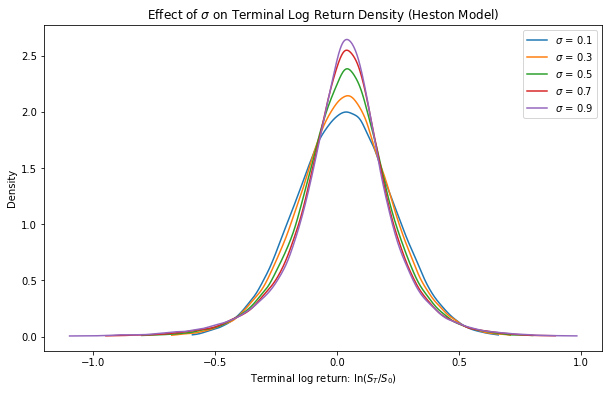

In [5]:
# Parameters
S0 = 100        # Initial stock price
v0 = 0.04       # Initial variance
mu = 0.05       # Drift rate
kappa = 2.0     # Speed of mean reversion
theta = 0.04    # Long-run variance
rho = 0      # Typical negative correlation for equities (leverage effect)
T = 1.0         # Total time horizon (1 year)
N = 252         # Number of time steps (daily)
M = 100000      # Number of simulation paths
seed = 42

# Values of sigma (vol-of-vol) to test
sigma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(10, 6))

for sigma in sigma_values:
    # Simulate Heston dynamics using the provided simulation function
    S_Heston, v_Heston = simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, M, seed=seed)
    
    # Compute terminal log return: x = ln(S_T/S_0)
    terminal_log_returns = np.log(S_Heston[-1] / S0)
    
    # Estimate density using Gaussian kernel density estimation
    density_estimator = gaussian_kde(terminal_log_returns)
    xs = np.linspace(np.percentile(terminal_log_returns, 0.1),
                     np.percentile(terminal_log_returns, 99.9), 1000)
    
    plt.plot(xs, density_estimator(xs), label=f"$\\sigma$ = {sigma}")

plt.xlabel("Terminal log return: $\\ln(S_T/S_0)$")
plt.ylabel("Density")
plt.title("Effect of $\\sigma$ on Terminal Log Return Density (Heston Model)")
plt.legend()
plt.show()

<u> **What do we see here ?** </u>

Note that we set $\rho = 0$. To demonstrate the effect clearly

Once again we can refer to Heston for an intuitive explanation : 

"*The parameter σ controls the volatility of volatility. When σ is zero, the volatility is deterministic, and continuously compounded spot returns have a normal distribution. Otherwise, σ increases the kurtosis of spot returns. Figure 3 shows how this creates two fat tails in the distribution of spot returns. [...] Note, however, that there is little effect on skewness.*"

We can plot the same graph but with negative correlation, as would be expected from market returns. We see that there is an effect on skewness but it is quite small : 

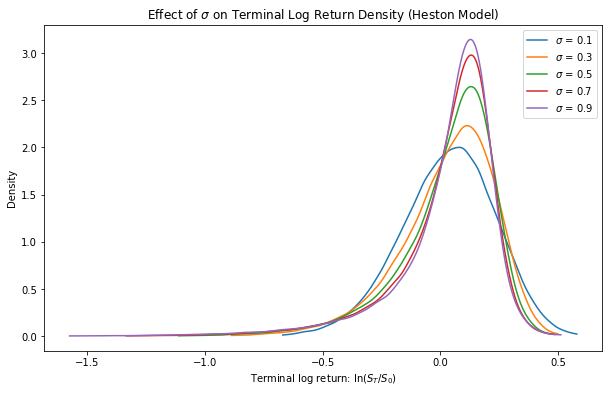

In [6]:
# Parameters
S0 = 100        # Initial stock price
v0 = 0.04       # Initial variance
mu = 0.05       # Drift rate
kappa = 2.0     # Speed of mean reversion
theta = 0.04    # Long-run variance
rho = -0.7      # Typical negative correlation for equities (leverage effect)
T = 1.0         # Total time horizon (1 year)
N = 252         # Number of time steps (daily)
M = 100000      # Number of simulation paths
seed = 42

# Values of sigma (vol-of-vol) to test
sigma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(10, 6))

for sigma in sigma_values:
    # Simulate Heston dynamics using the provided simulation function
    S_Heston, v_Heston = simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, M, seed=seed)
    
    # Compute terminal log return: x = ln(S_T/S_0)
    terminal_log_returns = np.log(S_Heston[-1] / S0)
    
    # Estimate density using Gaussian kernel density estimation
    density_estimator = gaussian_kde(terminal_log_returns)
    xs = np.linspace(np.percentile(terminal_log_returns, 0.1),
                     np.percentile(terminal_log_returns, 99.9), 1000)
    
    plt.plot(xs, density_estimator(xs), label=f"$\\sigma$ = {sigma}")

plt.xlabel("Terminal log return: $\\ln(S_T/S_0)$")
plt.ylabel("Density")
plt.title("Effect of $\\sigma$ on Terminal Log Return Density (Heston Model)")
plt.legend()
plt.show()

<a id='2.3' > </a>
## <u>2.3. Volatility clustering with the Heston model vs Black-Scholes

One of the advantages of the heston model, and stochastic volatility models in general, is that they exhibit one property that is also seen very often in market data : The squared log returns (aka sample volatilities) are autocorrelated.

In the following code section, we simulate the dynamics of a 'standard' Black-Scholes model (a.k.a. Geemetric Brownian Motion). We then simulate both GBM and Heston dynamics with the same parameters for both simulations. Finally, we compute the autocorrelation function of squared returns for both simulations and vizualize the results on a plot.

In [7]:
def simulate_gbm(S0, mu, sigma, T, N, M, seed=None):
    """
    Simulate Geometric Brownian Motion (GBM) for asset price dynamics.

    Parameters:
    - S0 (float): Initial asset price.
    - mu (float): Drift rate.
    - sigma (float): Constant volatility.
    - T (float): Total time horizon.
    - N (int): Number of time steps.
    - M (int): Number of simulation paths.
    - seed (int, optional): Seed for reproducibility.

    Returns:
    - S (ndarray): Simulated asset price paths with shape (N+1, M).
    """
    if seed is not None:
        np.random.seed(seed)
        
    dt = T / N
    S = np.zeros((N + 1, M))
    S[0] = S0
    for t in range(N):
        dW = np.sqrt(dt) * np.random.randn(M)
        S[t + 1] = S[t] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)
    return S

In [8]:
def average_acf_of_squared_returns(S, nlags=20):
    
    # Compute log returns: Δlog(S)
    returns = np.diff(np.log(S), axis=0)
    squared_returns = returns**2
    M = squared_returns.shape[1]
    acf_values = np.zeros((M, nlags + 1))
    
    for i in range(M):
        acf_values[i] = acf(squared_returns[:, i], nlags=nlags, fft=False)
        
    return acf_values.mean(axis=0)

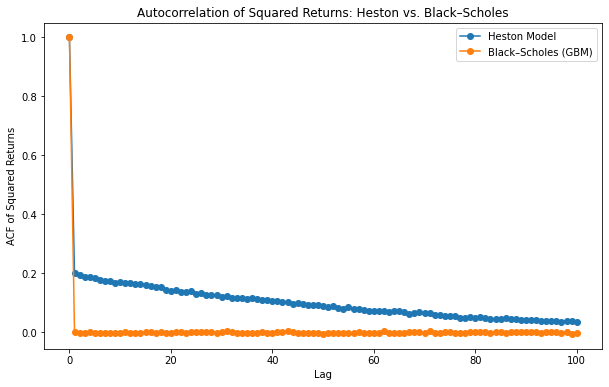

In [9]:
# Simulation parameters
S0 = 100
v0 = 0.04        # Initial variance for Heston
mu = 0.05
kappa = 2.0
theta = 0.04
sigma_heston = 0.5  # Vol-of-vol for Heston
rho = -0.7       # Typical negative correlation (leverage effect)
T = 5.0          # Total time horizon (5 years)
N = 252 * 5      # Number of time steps (daily steps over 5 years)
M = 200          # Number of simulation paths
seed = 42

# For Black–Scholes, use a constant volatility, typically sqrt(theta) or sqrt(v0)
sigma_BS = np.sqrt(theta)  # Here sigma_BS = 0.2

# Simulate Heston paths (assuming simulate_heston is already defined)
S_Heston, v_Heston = simulate_heston(S0, v0, mu, kappa, theta, sigma_heston, rho, T, N, M, seed=seed)

# Simulate Black–Scholes (GBM) paths
S_BS = simulate_gbm(S0, mu, sigma_BS, T, N, M, seed=seed)

# Compute the average ACF of squared returns
nlags = 100
acf_Heston = average_acf_of_squared_returns(S_Heston, nlags=nlags)
acf_BS = average_acf_of_squared_returns(S_BS, nlags=nlags)

# Plotting
lags = np.arange(nlags + 1)
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_Heston, marker='o', label='Heston Model')
plt.plot(lags, acf_BS, marker='o', label='Black–Scholes (GBM)')
plt.xlabel('Lag')
plt.ylabel('ACF of Squared Returns')
plt.title('Autocorrelation of Squared Returns: Heston vs. Black–Scholes')
plt.legend()
plt.show()

We can clearly see that the Heston model, with its stochastic volatility dynamics, displays the expectd effect of autocorrelation of squared returns.

<a id='2.4' > </a>
## <u>2.4. Mean reversion effect

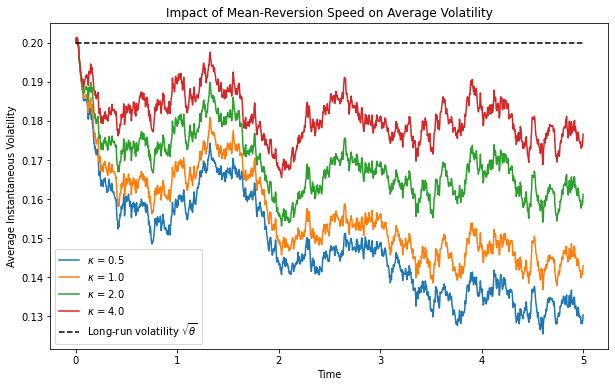

In [10]:
kappa_values = [0.5, 1.0, 2.0, 4.0]
plt.figure(figsize=(10, 6))

for k in kappa_values:
    _, v_temp = simulate_heston(S0, v0, mu, k, theta, sigma_heston, rho, T, N, M, seed=seed)
    # Average the instantaneous volatility (sqrt of variance) over all simulation paths
    avg_vol = np.mean(np.sqrt(v_temp), axis=1)
    plt.plot(np.linspace(0, T, N+1), avg_vol, label=f"$\\kappa$ = {k}")

plt.hlines(np.sqrt(theta), 0, T, colors='black', linestyles='dashed', label='Long-run volatility $\sqrt{\\theta}$')
plt.xlabel("Time")
plt.ylabel("Average Instantaneous Volatility")
plt.title("Impact of Mean-Reversion Speed on Average Volatility")
plt.legend()
plt.show()

Simple plot, we can clearly see how the value of $\kappa$ affects the speed of reversion to the long run volatility. This effect, although it seems not very useful is very important to the stock price dynamics. With no mean reversion, we would expect explosive values for volatility and paths that also tank to near zero values for volatility. This is why it is very important to have this term in the equations.

<a id='3' > </a>
# <u> 3. Pricing Comparison vs Black-Scholes

As Heston mentioned in this introductory article, his pricing model has multiple areas where it exceeds the predictions of Black-Scholes. The goal of the following section is to implement Heston pricing : First in the context of European options, then focus on some areas where the model exceeds Black-Scholes in terms of accuracy.

<a id='3.1' > </a>
## <u> 3.1 European options

<a id='3.1.1' > </a>
### <u> 3.1.1 Implementing Heston pricing

Heston, through the use of characteristic functions, Fourier inversion and Riccatti differential equations, is able to derive a semi analytical solution for European options.

$$
C = S \, P_1 - K \, e^{-rT} \, P_2,
$$

Where : 

$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_0^\infty \Re\left[ \frac{e^{-i u \ln(K)} f_j(u)}{i u} \right] du,\quad j=1,2,
$$

Where : 

$$
f_j(u) = \exp\Bigl( C_j(u) + D_j(u)\, v_0 + i u \ln S \Bigr),
$$

Where : 

$$
C_j(u) = i u r T + \frac{\kappa \theta}{\sigma^2} \left[ \left( \kappa - \rho \sigma \, i u - d_j(u) \right)T - 2 \ln\!\left(\frac{1 - g_j(u)\, e^{-d_j(u) T}}{1 - g_j(u)}\right) \right],
$$

$$
D_j(u) = \frac{\kappa - \rho \sigma \, i u - d_j(u)}{\sigma^2} \, \frac{1 - e^{-d_j(u) T}}{1 - g_j(u)\, e^{-d_j(u) T}},
$$

Where : 

$$
d(u) = \sqrt{ \Bigl( \rho \sigma \, i u - \kappa \Bigr)^2 + \sigma^2 \Bigl( u^2 + i u \lambda \Bigr) }.
$$

$$
g(u) = \frac{ \kappa - \rho \sigma \, i u - d(u) }{ \kappa - \rho \sigma \, i u + d(u) }.
$$


This formula is called "semi-analytical" because, while the characteristic functions $\phi_j(u)$ are available in closed form, the final pricing expression involves one-dimensional integrals that are typically computed numerically.

There are a lot of "Where" because else the function would be unreadable. But to sum up, there are 8 parameters : 

   - Market parameters: $S_0$, $K$, $T$, $r$.
   - Heston parameters: $\kappa$, $\theta$, $\sigma$, $\rho$, $v_0$ (calibrated to market data).

The pricing process therefore involves calibrating the Heston parameters to the data of the very stock we are analyzing, deciding on a risk-free rate and then inputing the data of the option we want to price, namely the spot, the strike and the maturity.

___

**Note that there are a lot of papers extending Heston's semi-analytical formula in order to make it more time-efficient and/or computationally efficient. These are subjects for an other notebook, we will stick to the solution proposed by Heston in his 1993 paper** 

In [11]:
import numpy as np
from scipy.integrate import quad

def heston_integrand(u, j, S, K, T, r, kappa, theta, sigma, v0, rho):
    """
    Compute the integrand (for either probability term) in the semi-analytical Heston formula.
    
    Parameters:
      u     : integration variable (float)
      j     : indicator (1 for P1; 0 for P2)
      S, K, T, r, kappa, theta, sigma, v0, rho : model parameters
      
    Returns:
      The real part of the integrand.
    """
    # Forward price and log-moneyness
    F = S * np.exp(r * T)
    x = np.log(F / K)
    gamma = sigma**2 / 2.0

    # Set up the quantities that differ for j==1 vs. j==0.
    if j == 1:
        alpha = -0.5 * u**2 + 0.5j * u
        beta  = kappa - rho * sigma - rho * sigma * 1j * u
    else:
        alpha = -0.5 * u**2 - 0.5j * u
        beta  = kappa - rho * sigma * 1j * u

    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    rplus  = (beta + d) / (2 * gamma)
    rminus = (beta - d) / (2 * gamma)
    g = rminus / rplus

    D = rminus * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
    C = kappa * (rminus * T - 2 / (sigma**2) * np.log((1 - g * np.exp(-d * T)) / (1 - g)))

    integrand_val = np.exp(C * theta + D * v0 + 1j * u * x) / (1j * u)
    return np.real(integrand_val)

def heston_call_price(S, K, T, r, kappa, theta, sigma, v0, rho):
    """
    Compute the European call option price under the Heston model using the closed-form solution.
    
    Parameters:
      S, K, T, r      : asset price, strike, time-to-maturity, risk-free rate
      kappa, theta, sigma, v0, rho : Heston model parameters
      
    Returns:
      The European call option price (float).
    """
    # Compute the two probability terms via Fourier inversion
    integral1, _ = quad(heston_integrand, 0, np.inf,
                        args=(1, S, K, T, r, kappa, theta, sigma, v0, rho),
                        limit=1000)
    P1 = 0.5 + integral1 / np.pi

    integral2, _ = quad(heston_integrand, 0, np.inf,
                        args=(0, S, K, T, r, kappa, theta, sigma, v0, rho),
                        limit=1000)
    P2 = 0.5 + integral2 / np.pi

    return S * P1 - K * np.exp(-r * T) * P2

# Test : Set Parameters 
S     = 100.0   # Current asset price
K     = 100.0   # Strike price
T     = 1.0     # Time to maturity
r     = 0.05    # Risk-free rate
kappa = 1.5     # Mean-reversion speed
theta = 0.04    # Long-run variance
sigma = 0.3     # Volatility of variance (vol-of-vol)
v0    = 0.04    # Initial variance
rho   = -0.7    # Correlation

price = heston_call_price(S, K, T, r, kappa, theta, sigma, v0, rho)
print("Heston call price =", price)


Heston call price = 10.361869020966118


Now That we have our model implemented. Before trying to fit it to market data, let's see if it fits some of the properties of what we would expect from our pricing model.

<a id='3.1.2' > </a>
### <u> 3.1.2. Convergence towards the same value with a monte Carlo simulation

This part is a sanity check. We perform a Monte Carlo Simulation on the price of a call to try and see whether the semi analytical solution has a close value.

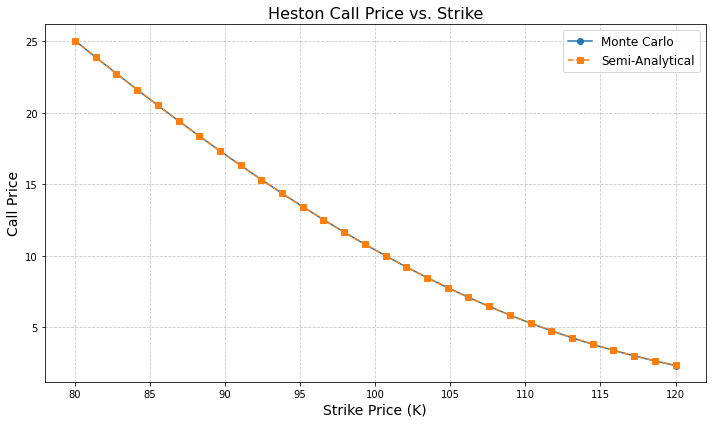

In [12]:
def monte_carlo_heston_call(S0, K, T, r, kappa, theta, sigma, v0, rho, N, M, seed=None):
    """
    Price a European call under the Heston model using Monte Carlo simulation.
    
    Parameters:
      (All parameters as above, with K being the strike, and T, r for time and risk-free rate.)
      
    Returns:
      price (float): The Monte Carlo call price.
    """
    # Use risk-neutral drift (mu = r)
    S, _ = simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M, seed)
    payoff = np.maximum(S[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

# Model parameters:
S0    = 100.0    # Spot price
r     = 0.05     # Risk-free rate (also used as drift for risk-neutral simulation)
T     = 1.0      # Maturity (years)
kappa = 2.0      # Mean reversion speed
theta = 0.04     # Long-run variance
v0    = 0.04     # Initial variance
rho   = -0.7     # Correlation
sigma = 0.3      # Vol-of-vol

# Simulation parameters:
N = 252           # Time steps
M = 100000        # Number of Monte Carlo paths
seed = 42

#Define a range of values for the strike:
K_values = np.linspace(80, 120, num=30)

# For Monte Carlo, simulate once and use the terminal asset prices.
S_paths, _ = simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M, seed=seed)
S_T = S_paths[-1]
mc_prices = [np.exp(-r*T)*np.mean(np.maximum(S_T - K_val, 0)) for K_val in K_values]

semi_prices = [heston_call_price(S0, K_val, T, r, kappa, theta, sigma, v0, rho) for K_val in K_values]

plt.figure(figsize=(10, 6))
plt.plot(K_values, mc_prices, marker='o', linestyle='-', label='Monte Carlo')
plt.plot(K_values, semi_prices, marker='s', linestyle='--', label='Semi-Analytical')
plt.title('Heston Call Price vs. Strike', fontsize=16)
plt.xlabel('Strike Price (K)', fontsize=14)
plt.ylabel('Call Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

We can barely see the difference, which is good but not a given because the computation of the integrand is tricky and can lead to all sorts of computation problems.

<a id='3.1.3' > </a>
### <u> 3.1.3. Strike dependency

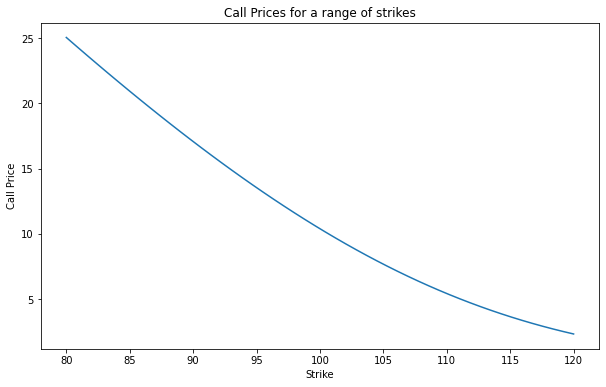

In [13]:
# Parameters :
S     = 100.0    # Spot price
T     = 1.0     # Time to maturity (in years)
r     = 0.05     # Risk-free rate
kappa = 2.0      # Mean reversion speed
theta = 0.04     # Long-term variance
sigma = 0.3      # Volatility of variance (vol-of-vol)
v0    = 0.04     # Initial variance
rho   = -0.7     # Correlation between asset and variance

K_values = np.linspace(80,120, num=50)
C_results = []

for K in K_values:
    C_results.append(heston_call_price(S, K, T, r, kappa, theta, sigma, v0, rho))

plt.figure(figsize = (10,6))
plt.plot(K_values, C_results)
plt.title('Call Prices for a range of strikes')
plt.xlabel('Strike')
plt.ylabel('Call Price')
plt.show()

For a range of strikes, we see that the model correctly outputs a shape that we would expect

<a id='3.1.4' > </a>
### <u> 3.1.4. Maturity Convergence

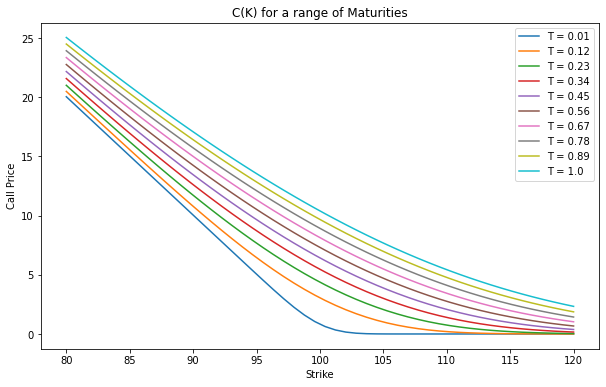

In [14]:
# Parameters :
S     = 100.0    # Spot price
r     = 0.05     # Risk-free rate
kappa = 2.0      # Mean reversion speed
theta = 0.04     # Long-term variance
sigma = 0.3      # Volatility of variance (vol-of-vol)
v0    = 0.04     # Initial variance
rho   = -0.7     # Correlation between asset and variance

K_values = np.linspace(80,120, num=50)
T_values = np.linspace(0.01,1, num=10)

plt.figure(figsize = (10,6))
for T in T_values:
    C_results = []
    for K in K_values:
        C_results.append(heston_call_price(S, K, T, r, kappa, theta, sigma, v0, rho))
        
    plt.plot(K_values, C_results, label=f'T = {T}')   

plt.title('C(K) for a range of Maturities')
plt.xlabel('Strike')
plt.ylabel('Call Price')
plt.legend()
plt.show()

As we can see, the skew slowly converges towards the payoff of a call as we are closer to maturity, as expected.

<a id='3.1.5' > </a>
### <u> 3.1.5. Falling back to Black-Scholes 

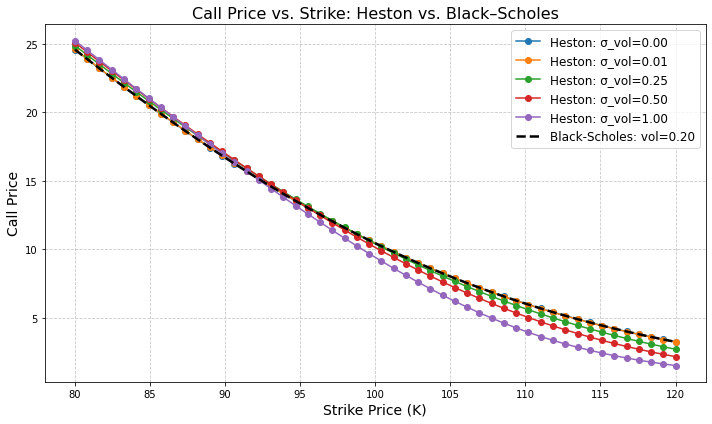

In [15]:
def bs_call_price(S, T, K, sigma, r):
    # For T=0, use intrinsic value
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

# Model parameters:
S     = 100.0    # Spot price
r     = 0.05     # Risk-free rate
T     = 1.0      # Maturity (years)
kappa = 2.0      # Mean reversion speed
theta = 0.04     # Long-term variance (and used as constant variance for BS)
v0    = 0.04     # Initial variance
rho   = -0.5     # Correlation

# Strike values:
K_values = np.linspace(80, 120, num=50)

# Heston: Test for various sigma (vol-of-vol) values. 
# To check the BS limit, we include a very small sigma value.
sigma_values = [0.001, 0.01, 0.25, 0.5, 1.0]

plt.figure(figsize=(10, 6))

for sigma in sigma_values:
    C_heston = [heston_call_price(S, K, T, r, kappa, theta, sigma, v0, rho) for K in K_values]
    label = f'Heston: σ_vol={sigma:.2e}' if sigma < 1e-6 else f'Heston: σ_vol={sigma:.2f}'
    plt.plot(K_values, C_heston, marker='o', linestyle='-', label=label)

# Black-Scholes call prices: using vol = sqrt(v0) = 0.2 (for v0=0.04)
vol_const = np.sqrt(v0)
C_BS = [bs_call_price(S, T, K, vol_const, r) for K in K_values]
plt.plot(K_values, C_BS, color='black', lw=2.5, linestyle='--', 
         label=f'Black-Scholes: vol={vol_const:.2f}')

# Enhance the plot aesthetics:
plt.title('Call Price vs. Strike: Heston vs. Black–Scholes', fontsize=16)
plt.xlabel('Strike Price (K)', fontsize=14)
plt.ylabel('Call Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

We See that the call price curve $C(K)$ converges to that of Black-Scholes, which is a property we expect since when $\sigma = 0$, a.k.a the vol of vol is 0, then the volatility becomes deterministic, just like the black-Scholes model.

<a id='3.2' > </a>
## <u> 3.2. Market Data

In order to calibrate and test our model against black-Scholes. For a given stock, we need :
- The spot price data in order to calibrate our model.
- The option data in order to test our model.

In [16]:
ticker = 'AAPL' #You can change the ticker here.

#Getting option data
stock = yf.Ticker(ticker) #Stock object
expirations = stock.options[1:] #Ordered List of expirations if we ever need it

spot = stock.history()['Close'].iloc[-1] #We get the last available close price as out spot

print(f'Spot for {ticker} : $ {spot}')

# Gather option call data from all expirations
options_list = []
for exp in expirations:
    chain = stock.option_chain(exp)
    calls = chain.calls.copy()
    # Compute maturity in years from today
    T = (pd.to_datetime(exp) - pd.to_datetime("today")).days / 365.0
    calls['maturity'] = T
    calls['expiration'] = exp
    options_list.append(calls)

option_data = pd.concat(options_list, ignore_index=True)
# Filter out options with non-positive prices to avoid noise
option_data = option_data[option_data['lastPrice'] > 0]

Spot for AAPL : $ 237.41000366210938


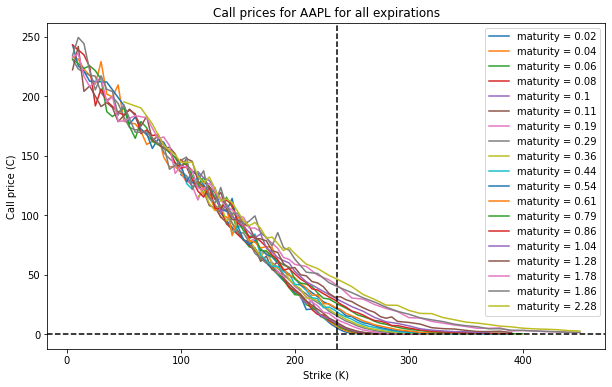

In [17]:
maturities = option_data['maturity'].unique()

plt.figure(figsize = (10,6))
for mat in maturities:
    option_data_mat = option_data[option_data['maturity'] == mat]
    X = option_data_mat['strike']
    Y = option_data_mat['lastPrice']
    plt.plot(X,Y,label = f'maturity = {round(mat,2)}')
    plt.legend()
plt.axvline(x = spot, color = 'k', linestyle = '--')
plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.title(f'Call prices for {ticker} for all expirations')
plt.ylabel('Call price (C)')
plt.xlabel('Strike (K)')
plt.show()

We can see that this is roughly the shape of what e saw earlier but with noise, especially in the low strike range.

<a id='3.3' > </a>
## <u> 3.3. Fitting a specific expiration

In order to speed up calculation, we use a Gauss Laguerre integrand calculation for the heston call price.

In [18]:
from numpy.polynomial.laguerre import laggauss

def heston_call_price_GL(S, K, T, r, kappa, theta, sigma, v0, rho, N=32):
    """
    Compute the Heston call price using Gauss-Laguerre quadrature.
    
    Parameters:
      S, K, T, r      : Spot price, strike, time-to-maturity, risk-free rate.
      kappa, theta, sigma, v0, rho : Heston model parameters.
      N               : Number of Gauss-Laguerre nodes.
    
    Returns:
      The European call price.
    """
    F = S * np.exp(r * T)
    x = np.log(F / K)
    gamma = sigma**2 / 2.0
    
    # Get Gauss-Laguerre nodes and weights
    nodes, weights = laggauss(N)
    
    def compute_integral(j):
        integral = 0.0
        for u, w in zip(nodes, weights):
            # Here, u is the quadrature node, and the integrand is modified by an exp(u)
            # to counter the exp(-u) weight in Gauss-Laguerre.
            u_val = u
            if j == 1:
                alpha = -0.5 * u_val**2 + 0.5j * u_val
                beta  = kappa - rho * sigma - rho * sigma * 1j * u_val
            else:
                alpha = -0.5 * u_val**2 - 0.5j * u_val
                beta  = kappa - rho * sigma * 1j * u_val

            d = np.sqrt(beta**2 - 4 * alpha * gamma)
            rplus  = (beta + d) / (2 * gamma)
            rminus = (beta - d) / (2 * gamma)
            g = rminus / rplus

            D = rminus * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
            C = kappa * (rminus * T - 2 / (sigma**2) * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
            integrand = np.exp(C * theta + D * v0 + 1j * u_val * x) / (1j * u_val)
            integral += w * np.real(np.exp(u_val) * integrand)
        return integral

    P1 = 0.5 + compute_integral(j=1) / np.pi
    P2 = 0.5 + compute_integral(j=0) / np.pi
    return S * P1 - K * np.exp(-r * T) * P2


Expiration: 2025-03-14 (T = 0.019 years)
Calibration Result:
  kappa: 1.00008972355803
  theta: 0.04078942194031106
  sigma: 0.29969537464975954
  v0   : 0.12173892674294995
  rho  : -0.5012064797992666
  Objective (sum squared error): 158.49904480468038


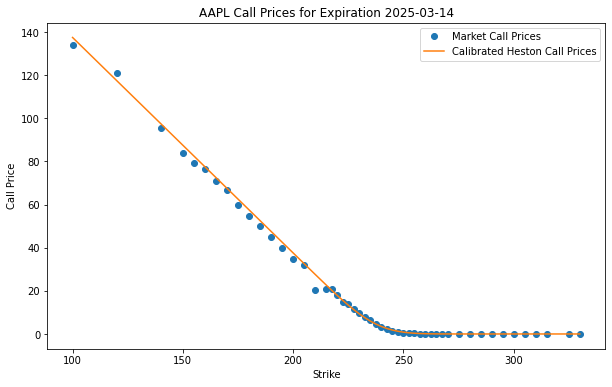


Expiration: 2025-03-21 (T = 0.038 years)
Calibration Result:
  kappa: 1.0051053941399435
  theta: 0.04772687278257238
  sigma: 1e-06
  v0   : 0.33015098825217515
  rho  : -0.09857333113179287
  Objective (sum squared error): 2443.3768926758808


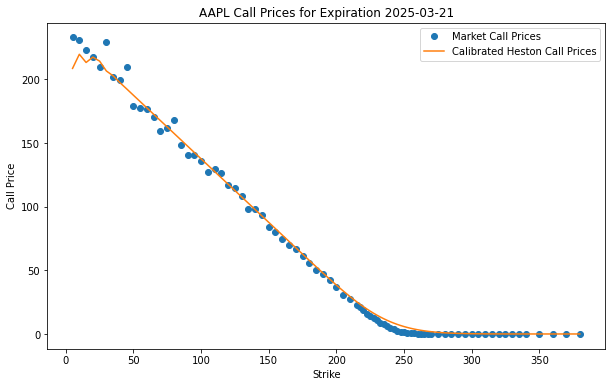


Expiration: 2025-03-28 (T = 0.058 years)
Calibration Result:
  kappa: 1.002021961507454
  theta: 0.05714938286709358
  sigma: 1e-06
  v0   : 0.07796701498406748
  rho  : -0.28737008037958406
  Objective (sum squared error): 193.61752425613525


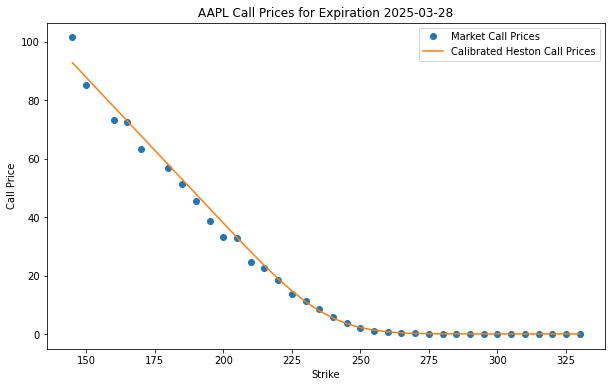


Expiration: 2025-04-04 (T = 0.077 years)
Calibration Result:
  kappa: 1.003005267038418
  theta: 0.0659450916082999
  sigma: 1e-06
  v0   : 0.07015271999915584
  rho  : -0.2819513210773512
  Objective (sum squared error): 331.39535895140347


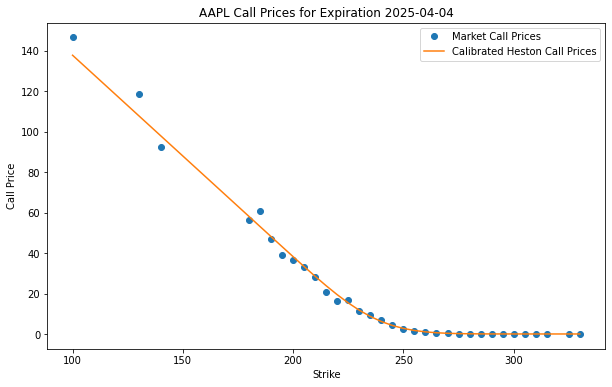


Expiration: 2025-04-11 (T = 0.096 years)
Calibration Result:
  kappa: 1.0086297669617794
  theta: 0.082558311778083
  sigma: 1e-06
  v0   : 0.05934905715627084
  rho  : -0.2187290170900539
  Objective (sum squared error): 38.19694252597372


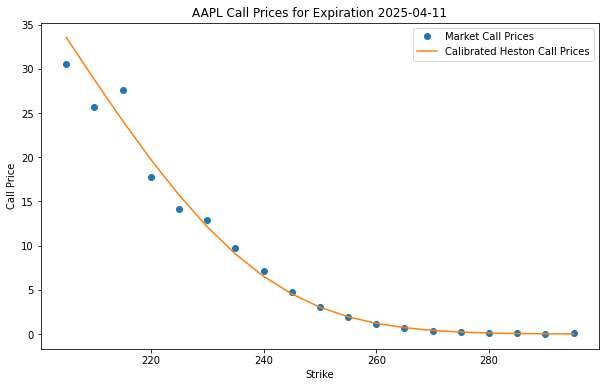


Expiration: 2025-04-17 (T = 0.112 years)
Calibration Result:
  kappa: 1.0021544587884954
  theta: 0.05826957360976858
  sigma: 0.0485664695222651
  v0   : 0.06695641339864813
  rho  : -0.4159997061309245
  Objective (sum squared error): 224.2523319321122


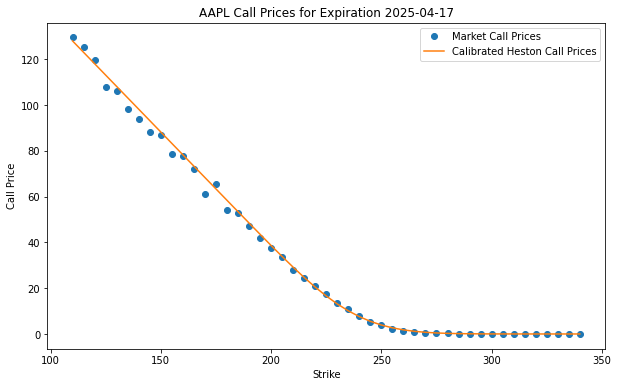


Expiration: 2025-05-16 (T = 0.192 years)
Calibration Result:
  kappa: 0.9982163915383446
  theta: 0.02943816528823411
  sigma: 0.4235668918233541
  v0   : 0.07543815077759526
  rho  : -0.5573349135833857
  Objective (sum squared error): 916.5383484057743


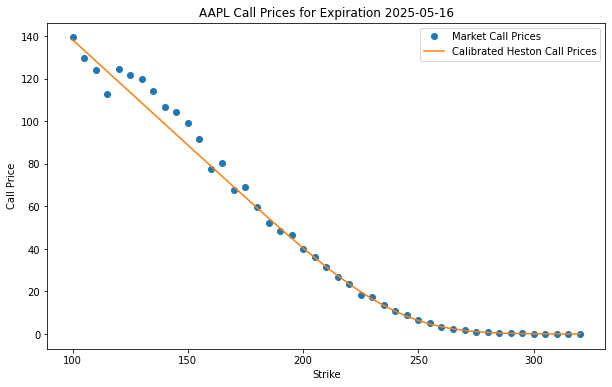


Expiration: 2025-06-20 (T = 0.288 years)
Calibration Result:
  kappa: 1.0084603332985325
  theta: 0.10974639672456246
  sigma: 1e-06
  v0   : 0.08652752022770635
  rho  : -0.26740575148024787
  Objective (sum squared error): 876.1117034610426


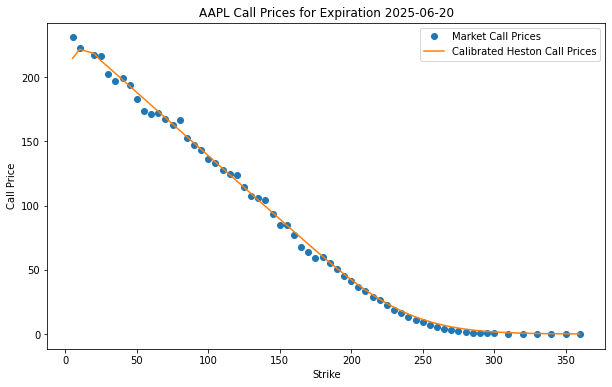


Expiration: 2025-07-18 (T = 0.364 years)
Calibration Result:
  kappa: 1.003570994652607
  theta: 0.07385345027167223
  sigma: 0.18895004762677942
  v0   : 0.056545683115202125
  rho  : -0.4500221642704004
  Objective (sum squared error): 328.4927128596494


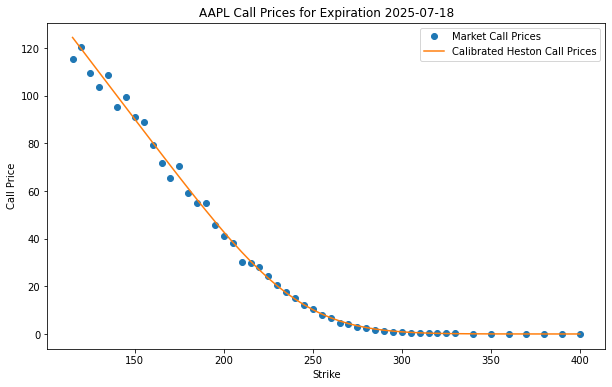


Expiration: 2025-08-15 (T = 0.441 years)
Calibration Result:
  kappa: 1.0048767152043694
  theta: 0.08584921876596589
  sigma: 0.17390192297703436
  v0   : 0.053261949864607784
  rho  : -0.43828084383968247
  Objective (sum squared error): 649.1751828633941


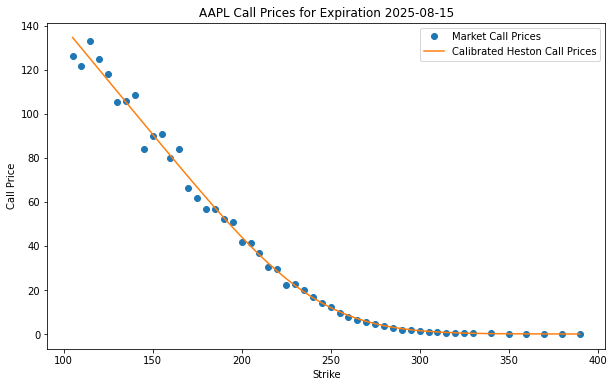


Expiration: 2025-09-19 (T = 0.537 years)
Calibration Result:
  kappa: 1.0447911537213939
  theta: 0.2071851918146613
  sigma: 0.008131401013166978
  v0   : 0.03105139218308105
  rho  : -0.2613706385638302
  Objective (sum squared error): 1767.7099009382132


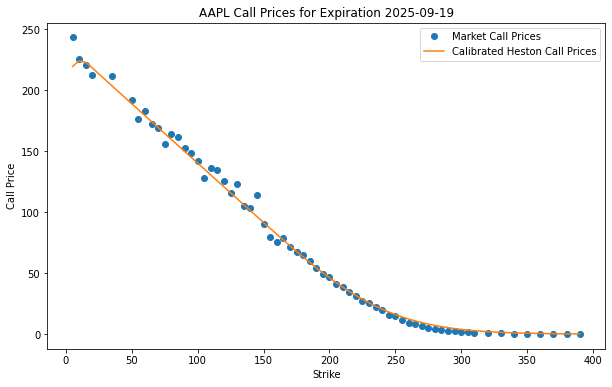


Expiration: 2025-10-17 (T = 0.614 years)
Calibration Result:
  kappa: 0.997470161220866
  theta: 0.07962198006673309
  sigma: 0.3699393754746543
  v0   : 0.051730918226949966
  rho  : -0.3658289419684029
  Objective (sum squared error): 545.2055438253929


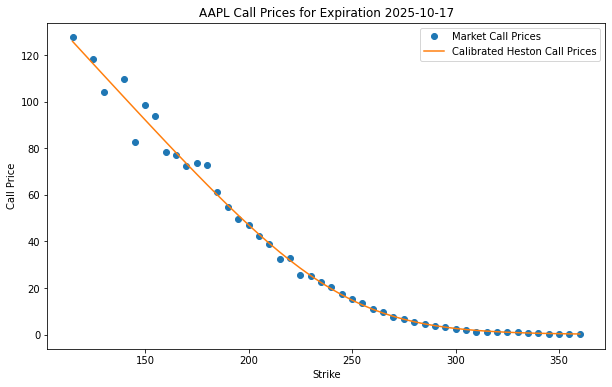


Expiration: 2025-12-19 (T = 0.786 years)
Calibration Result:
  kappa: 1.0509976095694658
  theta: 0.18420588757924683
  sigma: 0.003654650682059326
  v0   : 1e-06
  rho  : -0.34769320115076807
  Objective (sum squared error): 1697.1937398570005


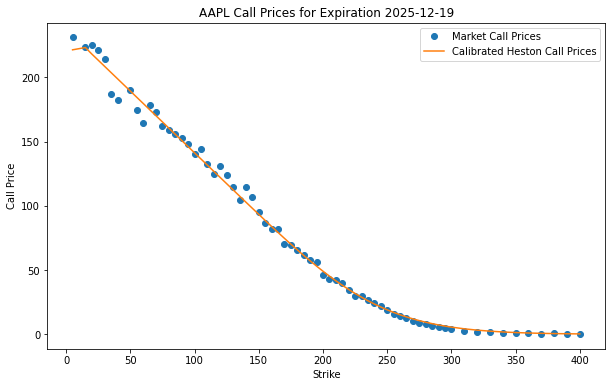


Expiration: 2026-01-16 (T = 0.863 years)
Calibration Result:
  kappa: 1.0410265781309036
  theta: 0.17379479945124443
  sigma: 1e-06
  v0   : 0.005969143203162033
  rho  : -0.4014089626217244
  Objective (sum squared error): 1898.0108787805125


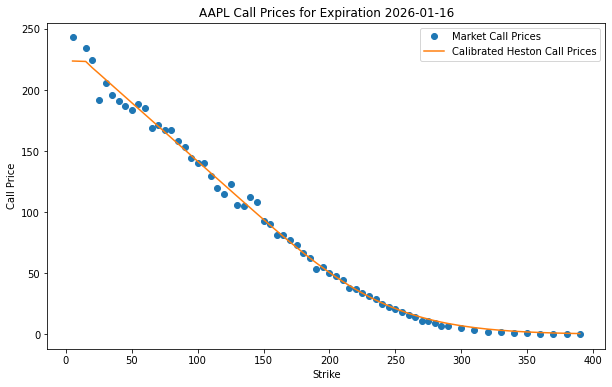


Expiration: 2026-03-20 (T = 1.036 years)
Calibration Result:
  kappa: 0.996297858129165
  theta: 0.0393731606899381
  sigma: 0.35495785916482814
  v0   : 0.07558074143489957
  rho  : -0.506508290227122
  Objective (sum squared error): 425.1584860034452


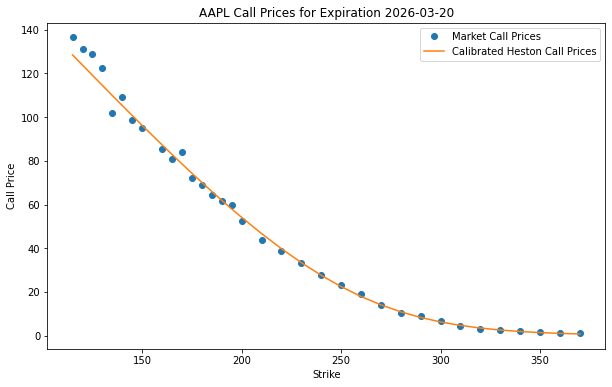


Expiration: 2026-06-18 (T = 1.282 years)
Calibration Result:
  kappa: 1.0186553169219177
  theta: 0.12043144978969139
  sigma: 0.17132844466473698
  v0   : 1e-06
  rho  : -0.4600732631576944
  Objective (sum squared error): 2181.414046217939


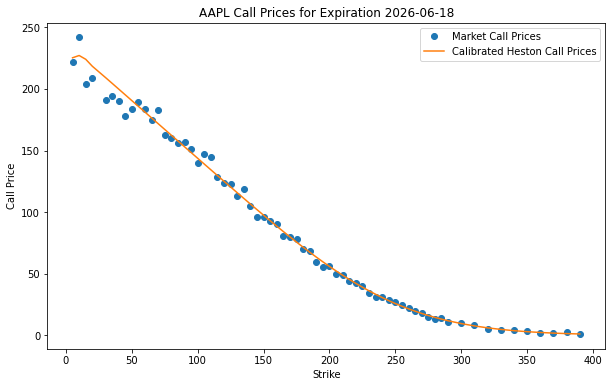


Expiration: 2026-12-18 (T = 1.784 years)
Calibration Result:
  kappa: 1.0360234752992064
  theta: 0.0944737745313325
  sigma: 0.036523023947214114
  v0   : 1e-06
  rho  : -0.4237562614788725
  Objective (sum squared error): 1442.0765743104432


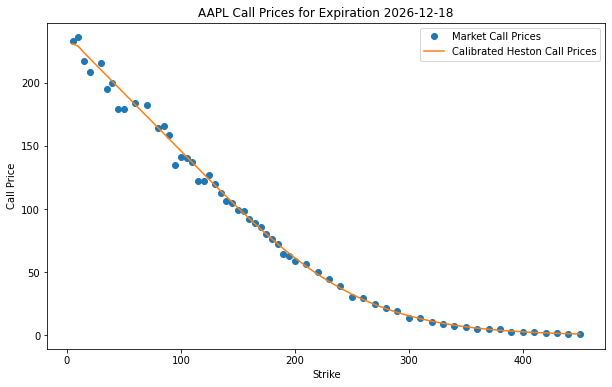


Expiration: 2027-01-15 (T = 1.860 years)
Calibration Result:
  kappa: 1.0175757373237764
  theta: 0.09204089113466206
  sigma: 0.2011341816997282
  v0   : 0.014391980839210042
  rho  : -0.5200408808150463
  Objective (sum squared error): 2676.662347513602


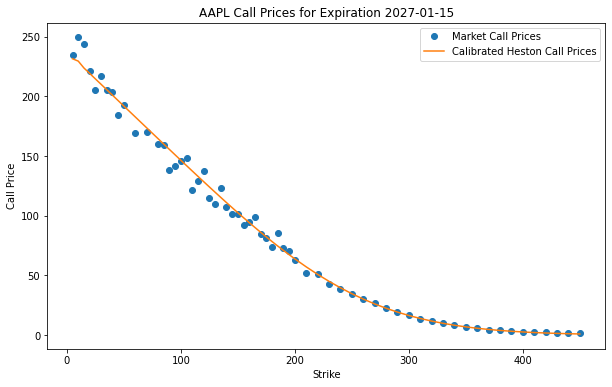


Expiration: 2027-06-17 (T = 2.279 years)
Calibration Result:
  kappa: 1.027481422895855
  theta: 0.0818538461644732
  sigma: 0.11784226775388036
  v0   : 1e-06
  rho  : -0.37303520527938466
  Objective (sum squared error): 439.94416540032205


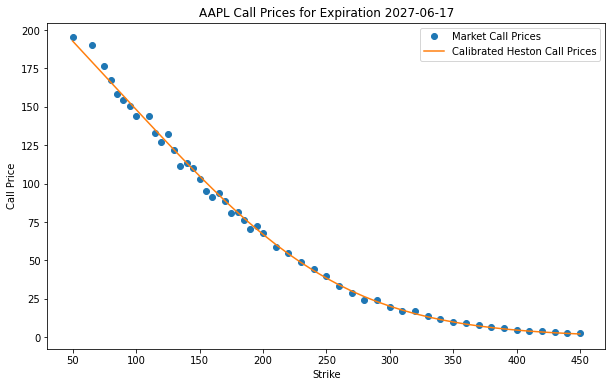

In [19]:
# Create a dictionary to store calibration results for each expiration
calibration_results = {}

# Loop over all expirations (or select a subset if desired)
for exp in expirations:
    # Extract option chain for this expiration
    try:
        call_option_data = stock.option_chain(exp).calls
    except Exception as e:
        print(f"Skipping expiration {exp}: {e}")
        continue

    # Compute time to expiration in years
    expiration_datetime = datetime.strptime(exp, "%Y-%m-%d")
    current_datetime = datetime.now()
    T = (expiration_datetime - current_datetime).days / 365.0
    if T <= 0:
        print(f"Skipping expired option {exp}")
        continue

    # Extract strikes and market prices (using last traded price)
    strikes = call_option_data['strike'].values
    market_prices = call_option_data['lastPrice'].values
    if len(strikes) == 0:
        print(f"No option data for expiration {exp}")
        continue

    # Define the objective function for this expiration.
    def objective(params):
        kappa, theta, sigma, v0, rho = params
        r = 0.05  # Adjust risk-free rate if needed.
        model_prices = np.array([
            heston_call_price_GL(spot, K, T, r, kappa, theta, sigma, v0, rho)
            for K in strikes
        ])
        error = np.sum((model_prices - market_prices) ** 2)
        return error

    # Initial guess and bounds for parameters
    x0 = [1.0, 0.04, 0.3, 0.04, -0.5]
    bounds = [(1e-6, None), (1e-6, None), (1e-6, None), (1e-6, None), (-0.999, 0.999)]
    
    # Perform calibration (here with limited iterations to speed up)
    result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B', options={'maxiter': 10})
    calibration_results[exp] = result.x

    # Output results
    print(f"\nExpiration: {exp} (T = {T:.3f} years)")
    print("Calibration Result:")
    print("  kappa:", result.x[0])
    print("  theta:", result.x[1])
    print("  sigma:", result.x[2])
    print("  v0   :", result.x[3])
    print("  rho  :", result.x[4])
    print("  Objective (sum squared error):", result.fun)

    # Plot the market vs calibrated Heston call prices for this expiration
    r = 0.05
    Heston_prices = np.array([
        heston_call_price_GL(spot, K, T, r, result.x[0], result.x[1], result.x[2], result.x[3], result.x[4])
        for K in strikes
    ])

    plt.figure(figsize=(10, 6))
    plt.plot(strikes, market_prices, 'o', label='Market Call Prices')
    plt.plot(strikes, Heston_prices, '-', label='Calibrated Heston Call Prices')
    plt.title(f'{ticker} Call Prices for Expiration {exp}')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.legend()
    plt.show()

<a id='3.4' > </a>
## <u> 3.4. Global fit

In order to assess whether a global fit makes sense we will look at the fitted parameters to see whether they changed a lot depending on the expiration 

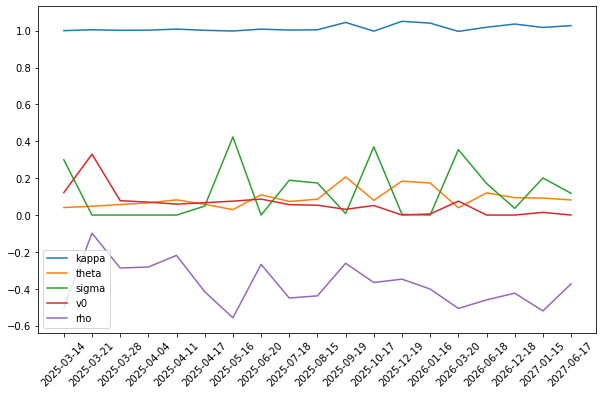

In [20]:
param_names = ['kappa', 'theta', 'sigma', 'v0', 'rho']
calib_df = pd.DataFrame.from_dict(calibration_results, orient='index', columns=param_names)

plt.figure(figsize=(10,6))
plt.plot(calib_df, label = calib_df.columns)
plt.xticks(rotation=45)
plt.legend()
plt.show()

It seems like the values hop around the initial values, except for sigma and rho, we can expect a global fit to give us a better full - scale model that fits better.

In [21]:
# Define the Calibration Objective Function 
def objective(params):
    kappa, theta, sigma, v0, rho = params
    error = 0.0
    # Loop over each option (global calibration across maturities and strikes)
    for _, row in option_data.iterrows():
        K = row['strike']
        T = row['maturity']
        market_price = row['lastPrice']
        # Compute model price using your Heston pricing function
        model_price = heston_call_price_GL(spot, K, T, r, kappa, theta, sigma, v0, rho)
        error += (market_price - model_price) ** 2
    return error

# Initial guess and bounds for the parameters:
# kappa, theta, sigma, v0 > 0, and rho between -1 and 1
initial_guess = [1.0, 0.04, 0.3, 0.04, -0.5]
bounds = [(0.001, 10), (0.001, 1), (0.001, 1), (0.001, 1), (-0.999, 0.999)]

# --- Calibrate the Parameters ---
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', options={'disp': True})
calibrated_params = result.x
print("Calibrated parameters: kappa, theta, sigma, v0, rho =", calibrated_params)

Calibrated parameters: kappa, theta, sigma, v0, rho = [10.          0.04247367  0.09461196  0.1654606   0.999     ]


3-D Plot of the option surface : 

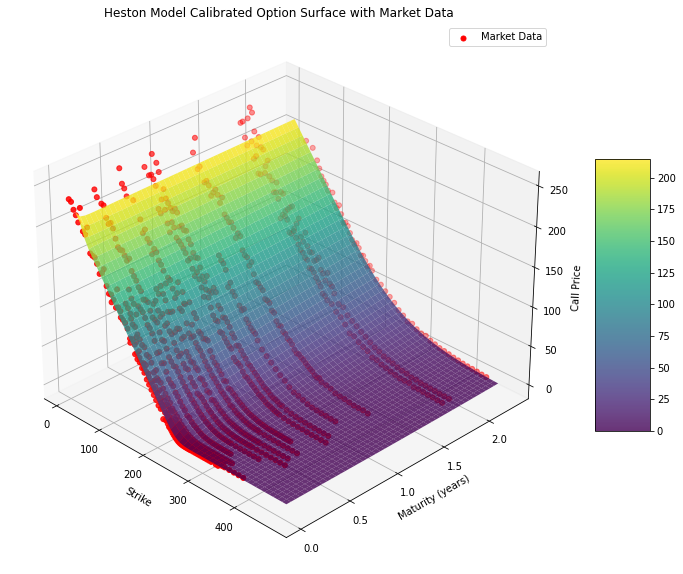

In [22]:
# Build a grid for strikes and maturities
strike_grid = np.linspace(0.1 * spot, 2 * spot, 50)
maturity_grid = np.linspace(option_data['maturity'].min(), option_data['maturity'].max(), 50)
Strike, Maturity = np.meshgrid(strike_grid, maturity_grid)

# Compute the call price at each grid point using the calibrated parameters
CallPrices = np.zeros_like(Strike)
for i in range(Strike.shape[0]):
    for j in range(Strike.shape[1]):
        CallPrices[i, j] = heston_call_price_GL(spot, Strike[i, j], Maturity[i, j], r, 
                                               calibrated_params[0],
                                               calibrated_params[1],
                                               calibrated_params[2],
                                               calibrated_params[3],
                                               calibrated_params[4])

# Plot the surface and overlay market prices as red dots
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(Strike, Maturity, CallPrices, cmap='viridis', alpha=0.8)
ax.view_init(elev=30, azim=315)

# Overlay market data points
ax.scatter(option_data['strike'], option_data['maturity'], option_data['lastPrice'], 
           color='r', marker='o', s=25, label='Market Data')

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity (years)')
ax.set_zlabel('Call Price')
ax.set_title('Heston Model Calibrated Option Surface with Market Data')
ax.legend()
fig.colorbar(surface, shrink=0.5, aspect=5)
plt.show()


* This is quite satisfying, we can see some errors on the very short maturities, this is due to the integrand which needs to take extreme values in order to converge in these cases. 
* Second issue is that we have simply assumed an interest rate. A more proper approach would be to get some yield curve rates data, bootstrap and compute some discount rates.

<a id='3.5' > </a>
## <u> 3.5. Pricing comparison

Now that we have a calibrated model, we can simply use it to price some options and see which model is closer to market prices.

/Users/jules.remlinger/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Historical annualized volatility for BS: 0.23747711993578366
Black Scholes RMSE: 4.1435911797071405
Black Scholes MAE: 2.408571356320889
Heston RMSE: 4.517339132560791
Heston MAE: 2.691369861987681


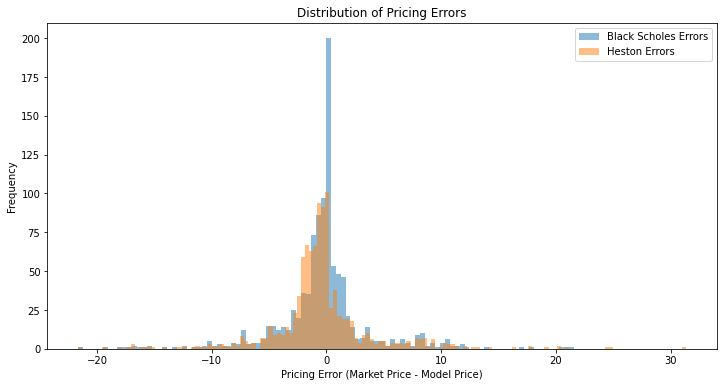

In [23]:
# Retrieve one year of historical data and compute daily log returns
hist = stock.history(period='1y')
returns = np.log(hist['Close'] / hist['Close'].shift(1))
# Annualize volatility (assuming ~252 trading days)
vol_bs = returns.std() * np.sqrt(252)
print("Historical annualized volatility for BS:", vol_bs)

#Compute Pricing Errors for Each Option
errors_bs = []
errors_heston = []

for idx, row in option_data.iterrows():
    K = row['strike']
    T = row['maturity']
    market_price = row['lastPrice']
    
    price_bs = bs_call_price(spot, T, K, vol_bs, r)
    price_heston = heston_call_price_GL(spot, K, T, r,
                                          calibrated_params[0],
                                          calibrated_params[1],
                                          calibrated_params[2],
                                          calibrated_params[3],
                                          calibrated_params[4])
    errors_bs.append(market_price - price_bs)
    errors_heston.append(market_price - price_heston)

errors_bs = np.array(errors_bs)
errors_heston = np.array(errors_heston)

# Compute Error Metrics (RMSE and MAE)
rmse_bs = np.sqrt(np.mean(errors_bs**2))
mae_bs = np.mean(np.abs(errors_bs))
rmse_heston = np.sqrt(np.mean(errors_heston**2))
mae_heston = np.mean(np.abs(errors_heston))

print("Black Scholes RMSE:", rmse_bs)
print("Black Scholes MAE:", mae_bs)
print("Heston RMSE:", rmse_heston)
print("Heston MAE:", mae_heston)

# --- Step 5: Plot Error Distributions ---
plt.figure(figsize=(12, 6))
plt.hist(errors_bs, bins=100, alpha=0.5, label="Black Scholes Errors")
plt.hist(errors_heston, bins=150, alpha=0.5, label="Heston Errors")
plt.xlabel("Pricing Error (Market Price - Model Price)")
plt.ylabel("Frequency")
plt.title("Distribution of Pricing Errors")
plt.legend()
plt.show()


We can see that the pricing is very close to one another, with Heston exhibiting more errors than Black-Scholes. This is probably due to the quality of our data which isn't optimal. 

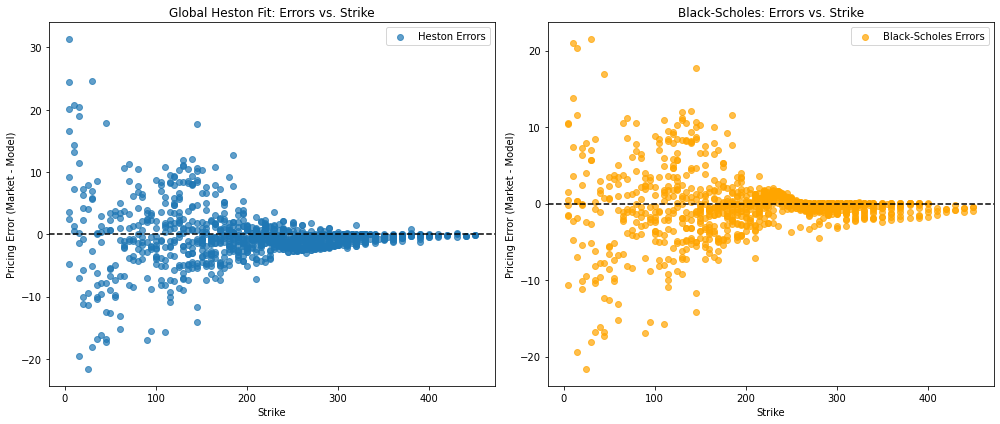

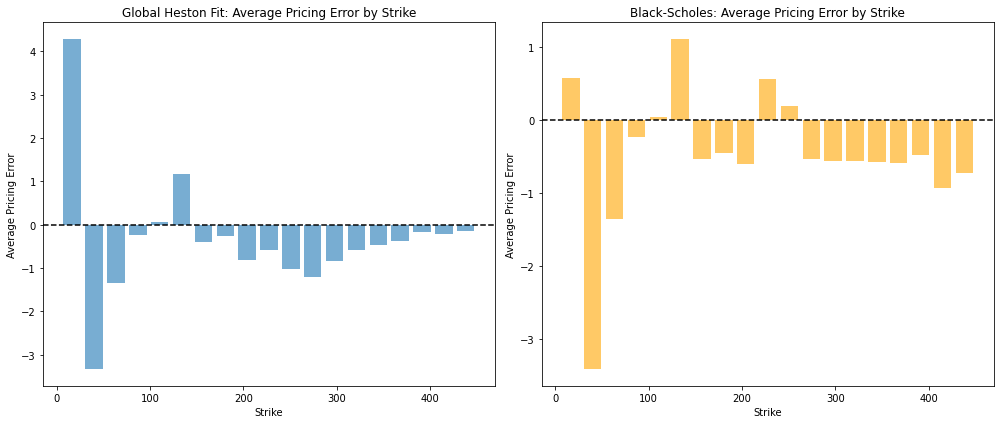

In [26]:
# --- Compute Errors for Both Models ---
heston_errors = []
bs_errors = []
strikes = []

for idx, row in option_data.iterrows():
    K = row['strike']
    T = row['maturity']
    market_price = row['lastPrice']
    strikes.append(K)
    
    # Heston global calibration price
    heston_price = heston_call_price_GL(spot, K, T, r,
                                         calibrated_params[0],
                                         calibrated_params[1],
                                         calibrated_params[2],
                                         calibrated_params[3],
                                         calibrated_params[4])
    heston_errors.append(market_price - heston_price)
    
    # Black-Scholes price
    bs_price = bs_call_price(spot, T, K, vol_bs, r)
    bs_errors.append(market_price - bs_price)

heston_errors = np.array(heston_errors)
bs_errors = np.array(bs_errors)
strikes = np.array(strikes)

# --- Plot 1: Scatter Plots of Pricing Errors vs. Strike ---

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Heston Scatter
axs[0].scatter(strikes, heston_errors, alpha=0.7, label='Heston Errors')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Pricing Error (Market - Model)")
axs[0].set_title("Global Heston Fit: Errors vs. Strike")
axs[0].legend()

# Black-Scholes Scatter
axs[1].scatter(strikes, bs_errors, alpha=0.7, color='orange', label='Black-Scholes Errors')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_xlabel("Strike")
axs[1].set_ylabel("Pricing Error (Market - Model)")
axs[1].set_title("Black-Scholes: Errors vs. Strike")
axs[1].legend()

plt.tight_layout()
plt.show()

# --- Plot 2: Bar Plots of Average Pricing Error by Strike Bin ---

# Define strike bins
bins = np.linspace(strikes.min(), strikes.max(), 20)
bin_indices = np.digitize(strikes, bins)

heston_bin_means = []
bs_bin_means = []
bin_centers = []

for b in range(1, len(bins)):
    # Heston errors in bin b
    heston_bin_errors = heston_errors[bin_indices == b]
    bs_bin_errors = bs_errors[bin_indices == b]
    if len(heston_bin_errors) > 0:
        heston_bin_means.append(np.mean(heston_bin_errors))
        bs_bin_means.append(np.mean(bs_bin_errors))
        # Center of the bin
        bin_centers.append((bins[b-1] + bins[b]) / 2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
width = (bins[1]-bins[0]) * 0.8

# Heston Bar Plot
axs[0].bar(bin_centers, heston_bin_means, width=width, alpha=0.6)
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Average Pricing Error")
axs[0].set_title("Global Heston Fit: Average Pricing Error by Strike")

# Black-Scholes Bar Plot
axs[1].bar(bin_centers, bs_bin_means, width=width, alpha=0.6, color='orange')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_xlabel("Strike")
axs[1].set_ylabel("Average Pricing Error")
axs[1].set_title("Black-Scholes: Average Pricing Error by Strike")

plt.tight_layout()
plt.show()

We could try to add filters on our data for liquidity or strikes and be able to get a better fit for Heston that actually beats Black-Scholes.